### Decomposing measures using PCA and t-sne

In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none" # use all for maximum output

from Wind.Results import DBResults, DBMeasures
from Wind.Util.Maps import create_mapbox_plot
from Wind.Private.DBConfig import mapbox_token
from Wind.Private.DBConfig import mongolocaltest, mongolocal, mongolocalmeasures

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import pearsonr, kendalltau,spearmanr, normaltest
import scipy.stats as stats

from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as skl

import sklearn
print('sklearn version :',sklearn.__version__)

sklearn version : 0.22.1


##### Internal Functions

In [18]:
def create_lat_lon(sites):
   list_sites = sites['site'].tolist()
   latlon_df = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/20190823Summary_file.csv')
   df = latlon_df.loc[latlon_df['site_number'].isin(list_sites)]
   return df

In [50]:
# plots 2x2 figure from PCA projection on 3 dims - similar articulo feng
def plot_PCA3(rater, min, max):
   plt.figure(figsize=(20,20))  
   print(rater.min(), rater.max())
   # Simula figura del articulo
   fig = plt.figure(figsize=(12,10))
   ax1 = fig.add_subplot(221, projection='3d')
   ax1.scatter(projected['PCA0'], projected['PCA1'], projected['PCA2'], c=rater, s=5, 
           cmap=plt.cm.get_cmap('Spectral',10), alpha=0.5, 
           norm = mpl.colors.Normalize(vmin=min,vmax=max))
   ax1.set_xlabel("PC1")
   ax1.set_ylabel("PC2")
   ax1.set_zlabel("PC3")
   ax1.set_title("PCA 3D")

   ax2 = fig.add_subplot(222)
   ax2.set_title('figura 2')
   ax2.set(xlabel = 'x-label', ylabel = 'y-label')
   ax2.scatter(projected['PCA0'], projected['PCA1'], c= rater, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10),
             norm = mpl.colors.Normalize(vmin=min,vmax=max))
    
   ax3 = fig.add_subplot(223)
   ax3.set_title('figura 3')
   ax3.scatter(projected['PCA1'], projected['PCA2'], c = rater, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10),
             norm = mpl.colors.Normalize(vmin=min,vmax=max))

   ax4 = fig.add_subplot(224)
   ax4.set_title('figura 4')
   ax4.scatter(projected['PCA0'], projected['PCA2'], c = rater, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10),
             norm = mpl.colors.Normalize(vmin=min,vmax=max))
   plt.show()
   return

In [25]:
query={'experiment':'JM_CNN_sep_2l_FULL', 'status':'done'}
results = DBResults(conn=mongolocal)
results.retrieve_results(query)

results.sample(1.0)
a12 = results.extract_result(dset='test', summary='sum', horizon = '12h')
a6  = results.extract_result(dset='test', summary='sum', horizon='6h')
a1  = results.extract_result(dset='test', summary='sum', horizon='1h')

##### Database Queries

In [34]:
query={'experiment':'JM_CNN_sep_2l_FULL', 'status':'done'}
# JM_RF_s2s_2, MLP_s2s_2
results = DBResults(conn=mongolocal)
results.retrieve_results(query)

results.sample(1.0)
a12 = results.extract_result(dset='test', summary='sum', horizon = '12h')
a6  = results.extract_result(dset='test', summary='sum', horizon='6h')
a1  = results.extract_result(dset='test', summary='sum', horizon='1h')

a12 = a12[a12[:,0].argsort()] # we sort by first column
a6 = a6[a6[:,0].argsort()] # we sort by first column
a1 = a1[a1[:,0].argsort()] # we sort by first column

measure = DBMeasures(conn=mongolocalmeasures)
measure.retrieve_measures()

a = a12

df_states = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/site-state/20191225SummaryFile(0.6)-arreglado.csv')

### We create df_data as master dataframe with all the measures

In [35]:
b1=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend12h')
b2=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SampEnt')
b3=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
b4=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend1m')
b5=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season24h')
b6=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season1m')
b7=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SpecEnt')
b8=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Stab1w')
b9=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Lump1w')

In [36]:
df_data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L_12h': a12[:,1], 'CNN_sep_2L_6h': a6[:,1],
                      'CNN_sep_2L_1h': a1[:,1],
                     'Trend12h_wind_speed':b1[:,1], 
                     'Trend24h_wind_speed':b3[:,1], 'Trend1m_wind_speed':b4[:,1],
                     'Season24h_wind_speed':b5[:,1], 'Season1m_wind_speed':b6[:,1], 'Season12h_wind_speed':b7[:,1],
                     'SampEnt_wind_speed':b2[:,1], 'SpecEnt_wind_speed':b7[:,1],
                     'Stab1w_wind_speed':b8[:,1], 'Lump1w_wind_speed':b9[:,1]})
df_data = df_data.dropna() # hay algun null por ahi limpiamos las filas erroneas

### Scatterplot Sampent with each prediction horizon 1h, 6h, 12h

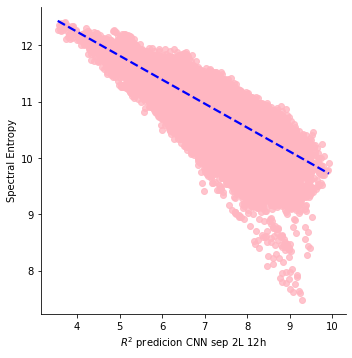

In [37]:
#12h
df_tmp = pd.DataFrame({'x':a12[:,1], 'y': b7[:,1]})

snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "lightpink"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L 12h', 'Spectral Entropy')

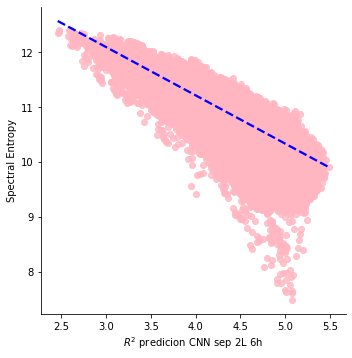

In [38]:
#6h
df_tmp = pd.DataFrame({'x':a6[:,1], 'y': b7[:,1]})

snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "lightpink"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L 6h', 'Spectral Entropy')

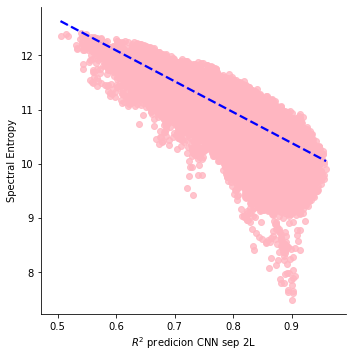

In [39]:
#1h
df_tmp = pd.DataFrame({'x':a1[:,1], 'y': b7[:,1]})

snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "lightpink"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L', 'Spectral Entropy')

### PCA analysis 

In [40]:
df_forPCA = pd.DataFrame({ 
                     'Trend12h_wind_speed':b1[:,1], 
                     'Trend24h_wind_speed':b3[:,1], 'Trend1m_wind_speed':b4[:,1],
                     'Season24h_wind_speed':b5[:,1], 'Season1m_wind_speed':b6[:,1], 'Season12h_wind_speed':b7[:,1],
                     'SampEnt_wind_speed':b2[:,1], 'SpecEnt_wind_speed':b7[:,1],
                     'Stab1w_wind_speed':b8[:,1], 'Lump1w_wind_speed':b9[:,1]})
df_forPCA = df_forPCA.dropna()
#data_sampled = data.sample(n=50000)

In [41]:
print(df_forPCA.columns)

Index(['Trend12h_wind_speed', 'Trend24h_wind_speed', 'Trend1m_wind_speed',
       'Season24h_wind_speed', 'Season1m_wind_speed', 'Season12h_wind_speed',
       'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
       'Lump1w_wind_speed'],
      dtype='object')


In [42]:
pca = PCA(3)  # project from 12 to 2 dimensions
pca.fit(df_forPCA)
projected = pd.DataFrame(pca.transform(df_forPCA), columns=['PCA%i' % i for i in range(3)], index=df_forPCA.index)
print(df_forPCA.shape)
print(projected.shape)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

(126661, 10)
(126661, 3)


In [43]:
print(df_data['CNN_sep_2L_1h'].max())

0.9589249813832003


In [44]:
##### PCA plot 1h, 6h, 12h

0.5050298192361149 0.9589249813832003


<Figure size 1440x1440 with 0 Axes>

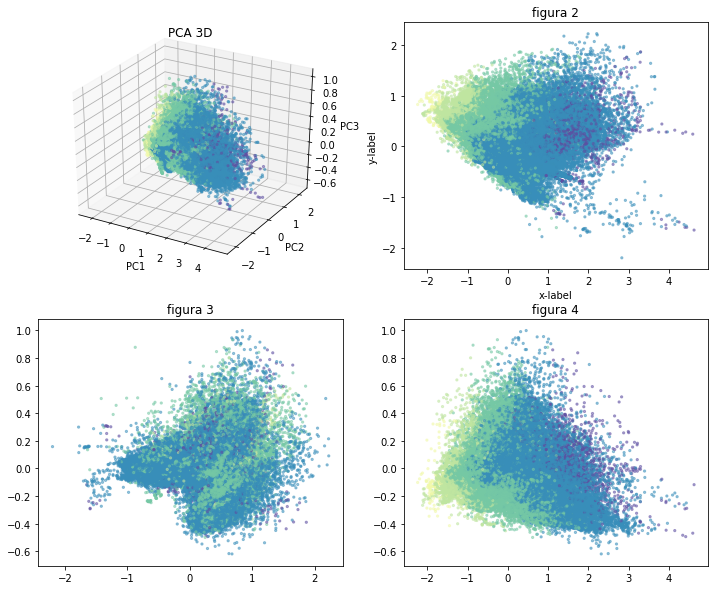

In [51]:
plot_PCA3(df_data.CNN_sep_2L_1h,0,1)

2.4599077151215445 5.488184120301994


<Figure size 1440x1440 with 0 Axes>

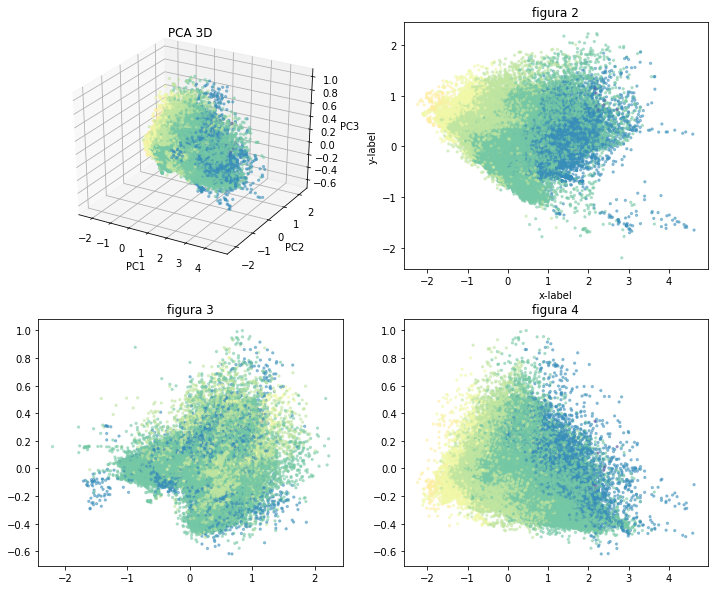

In [52]:
plot_PCA3(df_data.CNN_sep_2L_6h,0,6)

3.5439838785865057 9.915416362091458


<Figure size 1440x1440 with 0 Axes>

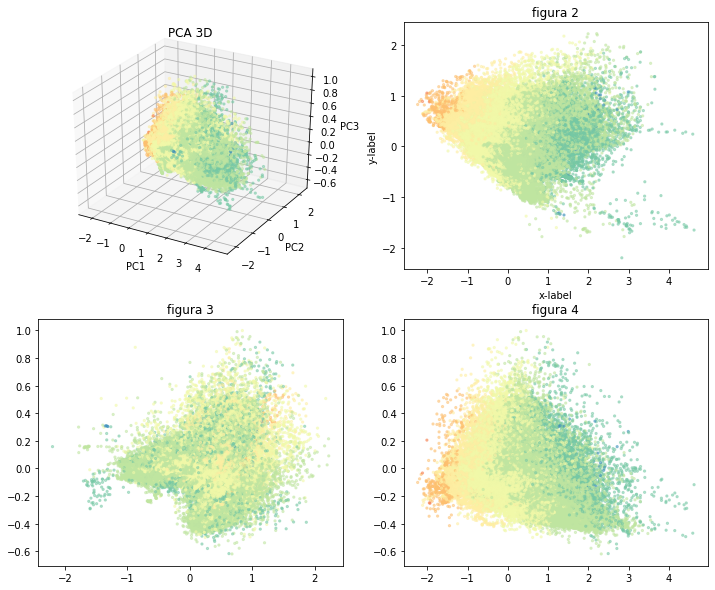

In [53]:
plot_PCA3(df_data.CNN_sep_2L_12h,0,12)

##### Limits are minimum and maximum values

0.5050298192361149 0.9589249813832003


<Figure size 1440x1440 with 0 Axes>

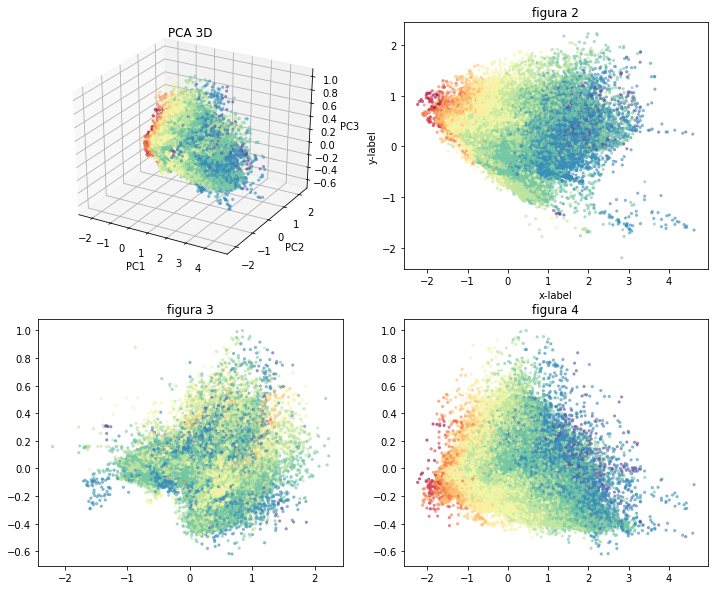

In [54]:
plot_PCA3(df_data.CNN_sep_2L_1h,df_data.CNN_sep_2L_1h.min(),df_data.CNN_sep_2L_1h.max())

2.4599077151215445 5.488184120301994


<Figure size 1440x1440 with 0 Axes>

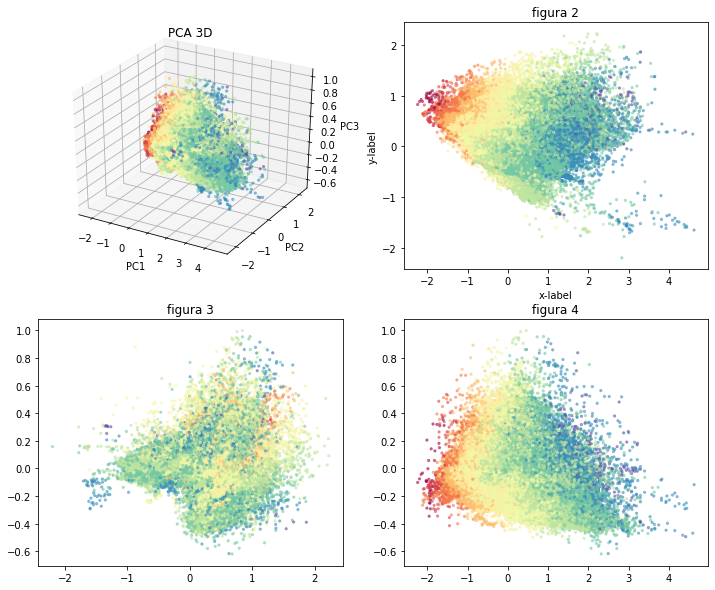

In [55]:
plot_PCA3(df_data.CNN_sep_2L_6h,df_data.CNN_sep_2L_6h.min(),df_data.CNN_sep_2L_6h.max())

3.5439838785865057 9.915416362091458


<Figure size 1440x1440 with 0 Axes>

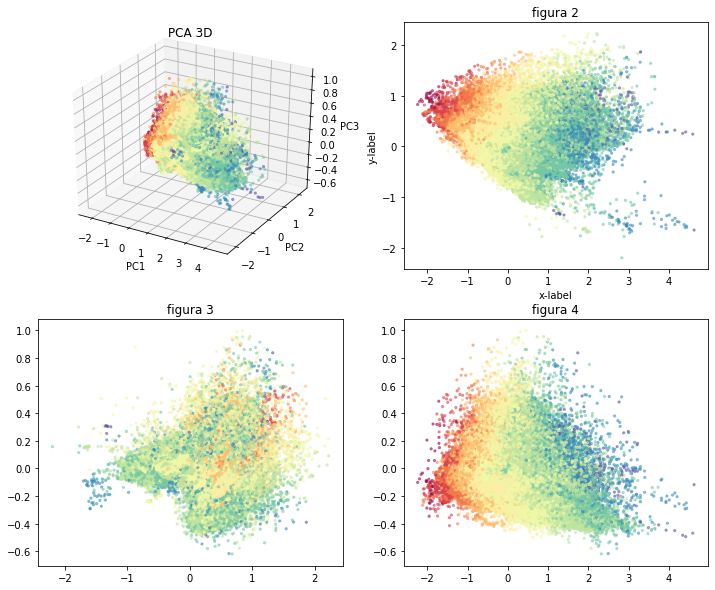

In [56]:
plot_PCA3(df_data.CNN_sep_2L_12h,df_data.CNN_sep_2L_12h.min(),df_data.CNN_sep_2L_12h.max())

Text(0.5, 0, 'PCA 1')

Text(0, 0.5, 'PCA 2')

Text(0.5, 1.0, 'PCA decomposition')

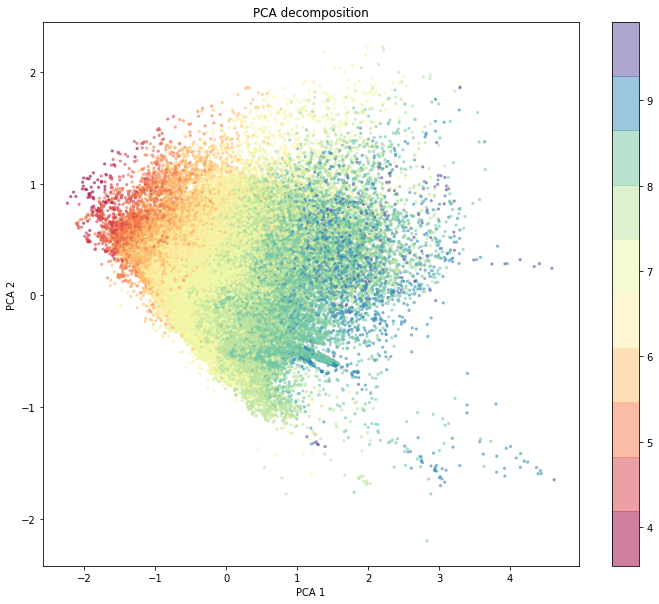

In [57]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)

plt.scatter(projected['PCA0'], projected['PCA1'], c=df_data.CNN_sep_2L_12h, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
ax.set_title('PCA decomposition')
plt.show()


### TSNE decomposition 2 components

In [61]:
tsne_em = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(df_forPCA)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 126661 samples in 0.578s...
[t-SNE] Computed neighbors for 126661 samples in 12.847s...
[t-SNE] Computed conditional probabilities for sample 1000 / 126661
[t-SNE] Computed conditional probabilities for sample 2000 / 126661
[t-SNE] Computed conditional probabilities for sample 3000 / 126661
[t-SNE] Computed conditional probabilities for sample 4000 / 126661
[t-SNE] Computed conditional probabilities for sample 5000 / 126661
[t-SNE] Computed conditional probabilities for sample 6000 / 126661
[t-SNE] Computed conditional probabilities for sample 7000 / 126661
[t-SNE] Computed conditional probabilities for sample 8000 / 126661
[t-SNE] Computed conditional probabilities for sample 9000 / 126661
[t-SNE] Computed conditional probabilities for sample 10000 / 126661
[t-SNE] Computed conditional probabilities for sample 11000 / 126661
[t-SNE] Computed conditional probabilities for sample 12000 / 126661
[t-SNE] Computed conditional probab

[t-SNE] Computed conditional probabilities for sample 120000 / 126661
[t-SNE] Computed conditional probabilities for sample 121000 / 126661
[t-SNE] Computed conditional probabilities for sample 122000 / 126661
[t-SNE] Computed conditional probabilities for sample 123000 / 126661
[t-SNE] Computed conditional probabilities for sample 124000 / 126661
[t-SNE] Computed conditional probabilities for sample 125000 / 126661
[t-SNE] Computed conditional probabilities for sample 126000 / 126661
[t-SNE] Computed conditional probabilities for sample 126661 / 126661
[t-SNE] Mean sigma: 0.017871
[t-SNE] KL divergence after 250 iterations with early exaggeration: 100.601105
[t-SNE] KL divergence after 1000 iterations: 3.047356


In [64]:
from matplotlib.colors import DivergingNorm

df_forPCA['tsne-2d-one'] = tsne_em[:,0]
df_forPCA['tsne-2d-two'] = tsne_em[:,1]


In [65]:

#norm = DivergingNorm(vmin=df1.CNN_sep_2L.min(), vcenter=6.5, vmax=df1.CNN_sep_2L.max())
#colors = [plt.cm.RdYlGn(norm(c)) for c in df1['CNN_sep_2L']]


##### TSNE 2D 1h

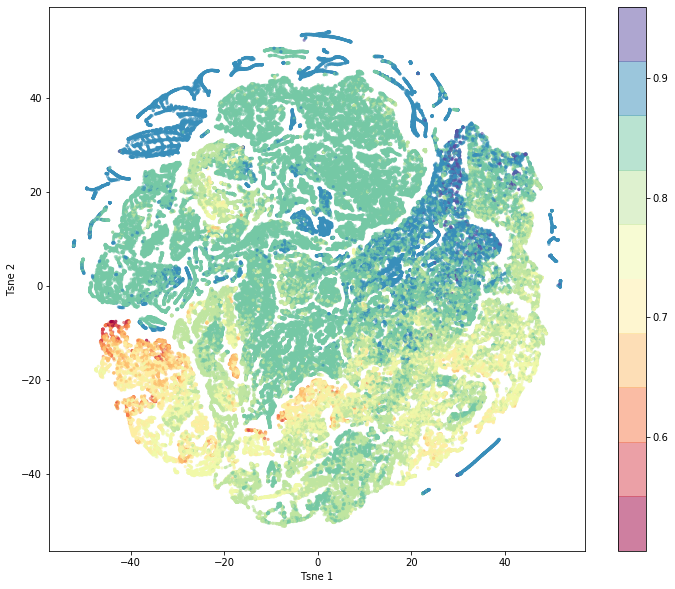

In [67]:
# Plot tsne 2D  MATPLOTLIB 

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
plt.scatter(df_forPCA['tsne-2d-one'], df_forPCA['tsne-2d-two'],c=df_data.CNN_sep_2L_1h, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Tsne 1')
plt.ylabel('Tsne 2')
plt.colorbar();
plt.show()

##### TSNE 2D 6h

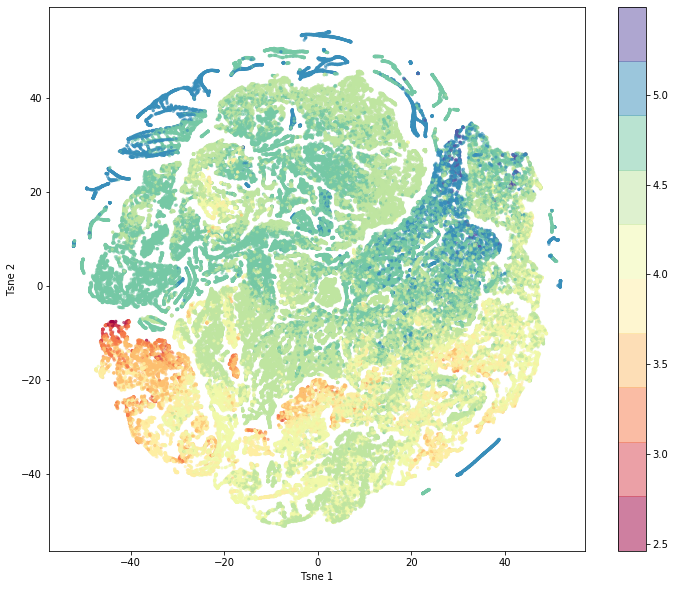

In [68]:
# Plot tsne 2D  MATPLOTLIB 

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
plt.scatter(df_forPCA['tsne-2d-one'], df_forPCA['tsne-2d-two'],c=df_data.CNN_sep_2L_6h, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Tsne 1')
plt.ylabel('Tsne 2')
plt.colorbar();
plt.show()

##### TSNE  2D 12h

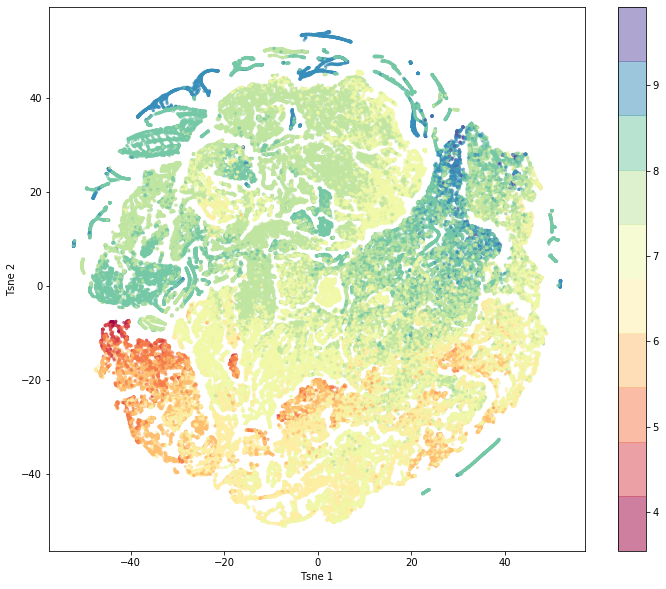

In [69]:
# Plot tsne 2D  MATPLOTLIB 

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
plt.scatter(df_forPCA['tsne-2d-one'], df_forPCA['tsne-2d-two'],c=df_data.CNN_sep_2L_12h, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Tsne 1')
plt.ylabel('Tsne 2')
plt.colorbar();
plt.show()